# Data.mat

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:

faces = loadmat('../data/data.mat')['face']
faces = faces.transpose([2,0,1]).reshape(600, 24, 21)

In [3]:
neutral_faces = faces[0::3,:,:]
exp_faces = faces[1::3,:,:]
illum_faces = faces[2::3,:,:]

neutral_faces.shape

(200, 24, 21)

In [4]:
X = np.concatenate([neutral_faces, exp_faces], axis=0)
X.shape

(400, 24, 21)

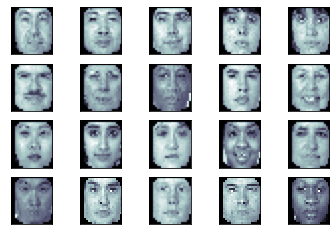

In [5]:
fig, ax = plt.subplots(4,5)

for i, axis in enumerate(ax.flat):
    axis.imshow(X[i, :, :], cmap='bone')
    axis.set(xticks=[], yticks=[])

In [6]:
# zeros are for neutral faces and ones are for smiling faces
Y = np.concatenate([np.zeros(200), np.ones(200)])

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    random_state=42,
    test_size=0.2,
    shuffle=True
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]) 

In [8]:
####
 # Standardizing the data before applying PCA
####

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


pca = PCA(n_components=15, whiten=False, random_state=42)
pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

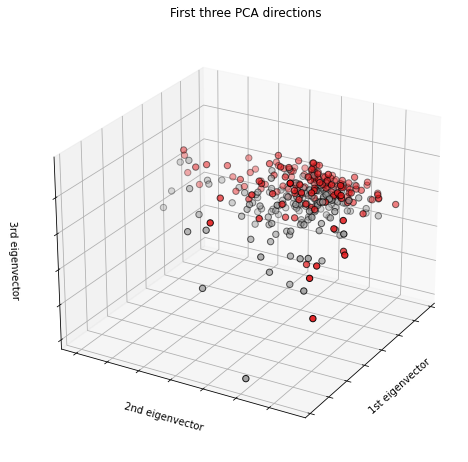

In [9]:
def PCA_viz(X, y):# this plot is used to show how the data is transformed after reducing it to 3d. Using 3 components results in worse accuracy.
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-155, azim=150)
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()
    
PCA_viz(X_train, Y_train)    

In [10]:
nb = GaussianNB()
nb.fit(X_train_reduced, Y_train)
nb_test_accuracy = nb.score(X_test_reduced, Y_test)
nb_pred = nb.predict(X_test_reduced)

nb_test_accuracy

0.95

In [11]:
nb_confusion_matrix = confusion_matrix(Y_test, nb_pred)

# confusion matrix in form of a pandas dataframe
nb_cm = pd.DataFrame(data=nb_confusion_matrix, columns=[['predicted','predicted'], ['neutral', 'smiling']],
                    index=[['actual','actual'], ['neutral','smiling']])
nb_cm

predicted        
                 neutral smiling
actual neutral        41       3
       smiling         1      35

In [12]:
knn_accuracies = []
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train_reduced, Y_train)
    knn_accuracies.append({
        f"neighbors_{i}": knn.score(X_test_reduced, Y_test)
    })

In [13]:
def count(accuracy, total_samples):
    return {
        "accuracy": accuracy,
        "correct": int(np.ceil(total_samples * accuracy)),
        "misclassified": int(np.ceil(total_samples * (1 - accuracy)))
    }

In [14]:
def plot_accuracies(accuracies):
    plt.plot(
        range(1, len(accuracies) + 1),
        [acc[f'neighbors_{i+1}'] for i, acc in enumerate(accuracies)],
    )
    plt.xlabel('neighbors')
    plt.ylabel('accuracy')
    plt.show()

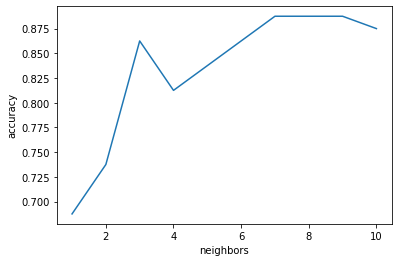

In [15]:
plot_accuracies(knn_accuracies)

In [16]:
percent_accuracies = [acc[f'neighbors_{i+1}'] for i, acc in enumerate(knn_accuracies)]
classfication_count = [count(acc, X_test.shape[0]) for acc in percent_accuracies]
classfication_count

[{'accuracy': 0.6875, 'correct': 55, 'misclassified': 25},
 {'accuracy': 0.7375, 'correct': 59, 'misclassified': 21},
 {'accuracy': 0.8625, 'correct': 69, 'misclassified': 11},
 {'accuracy': 0.8125, 'correct': 65, 'misclassified': 15},
 {'accuracy': 0.8375, 'correct': 67, 'misclassified': 13},
 {'accuracy': 0.8625, 'correct': 69, 'misclassified': 11},
 {'accuracy': 0.8875, 'correct': 71, 'misclassified': 10},
 {'accuracy': 0.8875, 'correct': 71, 'misclassified': 10},
 {'accuracy': 0.8875, 'correct': 71, 'misclassified': 10},
 {'accuracy': 0.875, 'correct': 70, 'misclassified': 10}]

In [17]:
# Fitting without using the scaler
pca = PCA(n_components=15, whiten=False, random_state=42)
pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

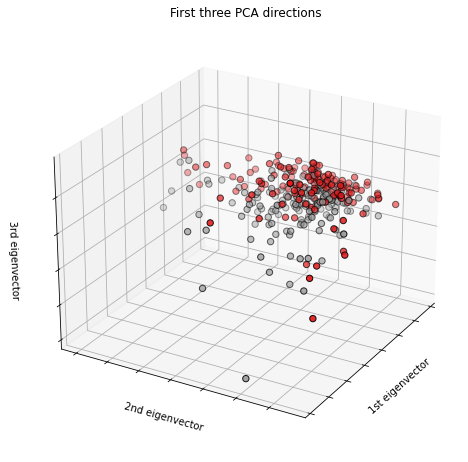

In [28]:
def PCA_viz(X, y):# this plot is used to show how the data is transformed after reducing it to 3d. Using 3 components results in worse accuracy.
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-155, azim=150)
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()
    
PCA_viz(X_train, Y_train)  

In [ ]:
nb = GaussianNB()
nb.fit(X_train_reduced, Y_train)
nb_test_accuracy = nb.score(X_test_reduced, Y_test)
nb_pred = nb.predict(X_test_reduced)

nb_test_accuracy

In [29]:
knn_accuracies = []
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train_reduced, Y_train)
    knn_accuracies.append({
        f"neighbors_{i}": knn.score(X_test_reduced, Y_test)
    })

In [30]:
def count(accuracy, total_samples):
    return {
        "accuracy": accuracy,
        "correct": int(np.ceil(total_samples * accuracy)),
        "misclassified": int(np.ceil(total_samples * (1 - accuracy)))
    }

In [31]:
def plot_accuracies(accuracies):
    plt.plot(
        range(1, len(accuracies) + 1),
        [acc[f'neighbors_{i+1}'] for i, acc in enumerate(accuracies)],
    )
    plt.xlabel('neighbors')
    plt.ylabel('accuracy')
    plt.show()

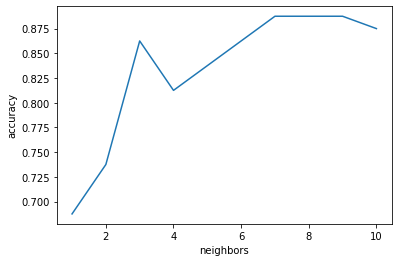

In [32]:
plot_accuracies(knn_accuracies)

In [33]:
percent_accuracies = [acc[f'neighbors_{i+1}'] for i, acc in enumerate(knn_accuracies)]
classfication_count = [count(acc, X_test.shape[0]) for acc in percent_accuracies]
classfication_count

[{'accuracy': 0.6875, 'correct': 55, 'misclassified': 25},
 {'accuracy': 0.7375, 'correct': 59, 'misclassified': 21},
 {'accuracy': 0.8625, 'correct': 69, 'misclassified': 11},
 {'accuracy': 0.8125, 'correct': 65, 'misclassified': 15},
 {'accuracy': 0.8375, 'correct': 67, 'misclassified': 13},
 {'accuracy': 0.8625, 'correct': 69, 'misclassified': 11},
 {'accuracy': 0.8875, 'correct': 71, 'misclassified': 10},
 {'accuracy': 0.8875, 'correct': 71, 'misclassified': 10},
 {'accuracy': 0.8875, 'correct': 71, 'misclassified': 10},
 {'accuracy': 0.875, 'correct': 70, 'misclassified': 10}]

Test sample size
The accuracy on the test set was optimal when the test size was 0.2 of the total 400 images. Reducing or increasing the test size achieved worse results.

random_state = 42 variable was set with PCA and train_test_split to make sure all the experiments were reproducible.

GaussianNB
The Naive Bayes' classfier GaussianNB fits on the data better than Nearest Neighbors Classifier and achieves an accuracy of 0.925, which is better than the best accuracy achieved my the nearest neighbors classifier. If we use the scaler for our traing set, we get higher accuracy which is 0.95, than withou using it.

KNearestNeighbors
After playing with value of PCA components, the best value found was 15. Below that achieved worse accuracies as most information from the features was lost. Thus, the accuracies were not as best. If we train using the scaler, we get higher accuracy on GaussianNB, but we get less accuracy on KnearestNeighbors.

# # Pose.mat


In [34]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [35]:
poses = loadmat('../data/pose.mat')['pose']
poses = poses.transpose([3, 2, 0 ,1]).reshape(68, 13, 48, 40)

TRAIN_POSE_COUNT = 7
TEST_POSE_COUNT = 13 - TRAIN_POSE_COUNT

# Normalize the data as well
# using the first 10 poses of each subject for train
X_train = poses[:, :TRAIN_POSE_COUNT, :, :]/255.

# using the last 3 poses of each subject for test
X_test = poses[:, TRAIN_POSE_COUNT:, :, :]/255.

In [36]:
def combine_images(arr):
    """
    Param: (np.arr) numpy 4D array
    Return: (np.arr) numpy 2D array with images combined 
    """
    
    return arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2], arr.shape[3])

X_train = combine_images(X_train)
X_test = combine_images(X_test)

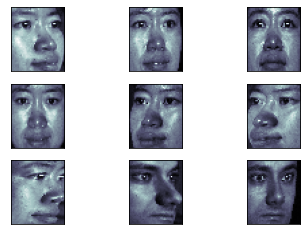

In [37]:
fig, ax = plt.subplots(3,3)

# first 9 images for one subject, each with a diff pose
for i, axis in enumerate(ax.flat):
    axis.imshow(X_train[i], cmap='bone')
    axis.set(xticks=[], yticks=[])

In [38]:
def get_flattened_features(arr): 
    """
    Param: (np.arr) numpy 3D array
    Return: (np.arr) numpy 2D array with flattened features 
    """
    return arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2])

In [39]:
X_train = get_flattened_features(X_train)
X_test = get_flattened_features(X_test)

In [40]:
X_train.shape, X_test.shape

((476, 1920), (408, 1920))

In [44]:
# each subject has 10 images consecutive in the train data 
Y_train = np.concatenate([np.ones(TRAIN_POSE_COUNT) * i for i in range(1, X_train.shape[0] // TRAIN_POSE_COUNT + 1)])

# each subject has 3 images consecutive in the test data 
Y_test = np.concatenate([np.ones(TEST_POSE_COUNT) * i for i in range(1, X_test.shape[0] // TEST_POSE_COUNT + 1)])

In [45]:
pca = PCA(n_components=65,
          whiten=False,
          random_state=42
        )

pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

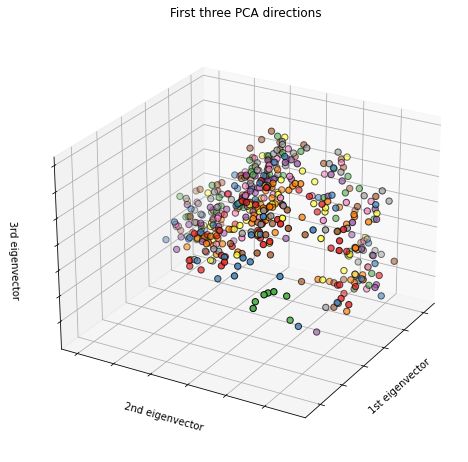

In [46]:
# visualising the reduced dimensions for the pose dataset after applying PCA
def PCA_viz(X, y):
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-155, azim=150)
    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()
    
PCA_viz(X_train, Y_train)   

# GaussianNB

# The naive bayes classifier does best when the PCA's ```n_compenents=16```, changing it only worsens ```nb_test_accuracy```

In [47]:
nb = GaussianNB()
nb.fit(X_train_reduced, Y_train)
nb_test_accuracy = nb.score(X_test_reduced, Y_test)

nb_test_accuracy

0.7107843137254902

In [48]:
knn_accuracies = []
for i in range(1, 5):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train_reduced, Y_train)
    knn_accuracies.append({
        f"neighbors_{i}": knn.score(X_test_reduced, Y_test)
    })

In [49]:
def count(accuracy, total_samples):
    return {
        "accuracy": accuracy,
        "correct": int(np.ceil(total_samples * accuracy)),
        "misclassified": int(np.ceil(total_samples * (1 - accuracy)))
    }

In [50]:
def plot_accuracies(accuracies):
    plt.plot(
        range(1, len(accuracies) + 1),
        [acc[f'neighbors_{i+1}'] for i, acc in enumerate(accuracies)],
    )
    plt.xlabel('neighbors')
    plt.ylabel('accuracy')
    plt.show()

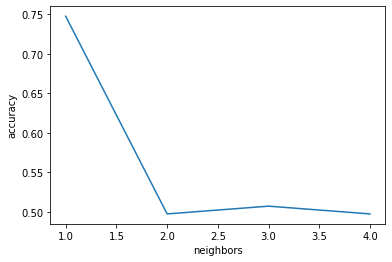

In [51]:
plot_accuracies(knn_accuracies)

In [52]:
percent_accuracies = [acc[f'neighbors_{i+1}'] for i, acc in enumerate(knn_accuracies)]
classfication_count = [count(acc, X_test.shape[0]) for acc in percent_accuracies]
classfication_count

[{'accuracy': 0.7475490196078431, 'correct': 305, 'misclassified': 103},
 {'accuracy': 0.49754901960784315, 'correct': 203, 'misclassified': 205},
 {'accuracy': 0.5073529411764706, 'correct': 207, 'misclassified': 201},
 {'accuracy': 0.49754901960784315, 'correct': 203, 'misclassified': 205}]